In [1]:
from collections import namedtuple

import pandas as pd
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as td

import pytorch_lightning as pl

import tqdm
import json
import sklearn.metrics as sm

import tensorboardX as tb
import tensorflow as tf
import datetime, os

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.spatial.distance import cdist
from collections import defaultdict
import warnings
warnings.filterwarnings("ignore")
np.random.seed(31337)

## Create pairs (first track, subsequent track, time)

In [2]:
data = pd.read_json("data_seminar_04.json", lines=True)

In [3]:
tracks = pd.read_json("../botify/data/tracks.json", lines=True)

Создадим словарь track->arist_idx, для того, чтобы рекомендовать следующий трек на основе авторов.

In [4]:
artist_set = set()
for (_, (artist, title, track)) in tracks.iterrows():
    if artist not in artist_set:
        artist_set.add(artist)
print(f"Num of artists: {len(artist_set)}")
artist_to_idx = {}
for idx, artist in enumerate(artist_set):
    artist_to_idx[artist] = idx

track_to_artist_idx = {}
for (_, (artist, title, track)) in tracks.iterrows():
    track_to_artist_idx[track] = artist_to_idx[artist]

Num of artists: 11464


In [5]:
Pair = namedtuple("Session", ["user", "start", "track", "time"])

def get_pairs(user_data):
    pairs = []
    first = None
    for _, row in user_data.sort_values("timestamp").iterrows():
        if first is None:
            first = row["track"]
        else:
            pairs.append(Pair(row["user"], first, row["track"], row["time"]))
        
        if row["message"] == "last":
            first = None
    return pairs

In [6]:
pairs = pd.DataFrame(
    data
    .groupby("user")
    .apply(get_pairs)
    .explode()
    .values
    .tolist(),
    columns=["user", "start", "track", "time"]
)

In [7]:
pairs["start_artist"] = pairs["start"].apply(lambda x: track_to_artist_idx[x])
pairs["end_artist"] = pairs["track"].apply(lambda x: track_to_artist_idx[x])

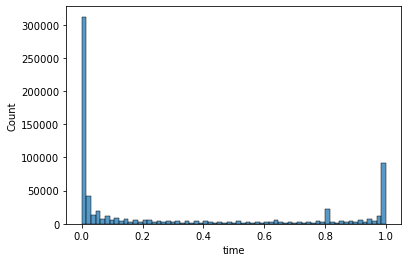

In [8]:
figure, ax = plt.subplots()
sns.histplot(pairs["time"], ax=ax)
pass

In [9]:
pairs[pairs["user"] == 0]

,user,start,track,time,start_artist,end_artist
0,0,2999,5089,0.0,2971,8073
1,0,2999,5992,0.0,2971,1227
2,0,2999,7960,0.0,2971,786
3,0,2999,1725,0.0,2971,1857
4,0,2999,2606,0.0,2971,10783
...,...,...,...,...,...,...
58,0,7984,10905,0.0,6315,4213
59,0,7984,1501,0.0,6315,4721
60,0,7984,6615,1.0,6315,3069
61,0,7984,101,0.0,6315,8601


## Train Model

In [10]:
rdm = np.random.random(len(pairs))
train_data = pairs[rdm < 0.8]
val_data = pairs[(rdm >= 0.8) & (rdm < 0.9)]
test_data = pairs[rdm >= 0.9]

len(train_data), len(val_data), len(test_data)

(572587, 70915, 71742)

In [11]:
train_data

,user,start,track,time,start_artist,end_artist
0,0,2999,5089,0.00,2971,8073
2,0,2999,7960,0.00,2971,786
3,0,2999,1725,0.00,2971,1857
4,0,2999,2606,0.00,2971,10783
7,0,31348,2224,0.00,2622,5264
...,...,...,...,...,...,...
715237,9999,2688,12,0.00,4386,8602
715240,9999,44241,2580,0.02,2819,11188
715241,9999,44241,7960,0.25,2819,786
715242,9999,44241,5372,0.00,2819,9196


In [12]:
class ContextualRanker(pl.LightningModule):
    def __init__(self, embedding_dim=32):
        super().__init__()
        self.embedding_dim = embedding_dim
        
        # We won't have embeddings for everything, but that's ok
        self.context = nn.Embedding(num_embeddings=50000, embedding_dim=self.embedding_dim)
        self.track = nn.Embedding(num_embeddings=50000, embedding_dim=self.embedding_dim)

        self.artists = nn.Embedding(num_embeddings=11464, embedding_dim=self.embedding_dim)
        
        self.cosine_dist = nn.CosineSimilarity(dim=-1)
        

    def forward(self, x):
        start_track = self.context(x[:, 0])
        end_track = self.track(x[:, 1])
        
        start_artist = self.artists(x[:, 2])
        end_artist = self.artists(x[:, 3])
            
        res = 0.9 *self.cosine_dist(start_track, end_track) + (1 - 0.9) * self.cosine_dist(start_artist, end_artist)
        return res
            
    def step(self, batch, batch_idx, metric, prog_bar=False):
        x, y = batch
        predictions = self.forward(x)
        loss = F.mse_loss(predictions, y.float(), reduction='mean')
        self.log(metric, loss, prog_bar=prog_bar)
        return loss

    def test_step(self, batch, batch_idx, prog_bar=False):
        x, y = batch
        predictions = self.forward(x)
        targets = y[:, 0].float()
        avgs = y[:, 1].float()
        rdms = y[:, 2].float()

        loss = F.mse_loss(predictions, targets, reduction='mean')
        avg_loss = F.mse_loss(avgs, targets, reduction='mean')
        rdm_loss = F.mse_loss(rdms, targets, reduction='mean')

        self.log("test_loss", loss, prog_bar=prog_bar)
        self.log("avg_loss", avg_loss, prog_bar=prog_bar)
        self.log("rdm_loss", rdm_loss, prog_bar=prog_bar)

    def training_step(self, batch, batch_idx):
        return self.step(batch, batch_idx, "train_loss")
    
    def validation_step(self, batch, batch_idx):
        return self.step(batch, batch_idx, "val_loss", True)
        
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3, weight_decay=1e-5)
        lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3, verbose=True)
        scheduler = {
            'scheduler': lr_scheduler,
            'reduce_on_plateau': True,
            'monitor': 'val_loss'
        }
        return [optimizer], [scheduler]

In [13]:
class ContextualRankerData(pl.LightningDataModule):
    def __init__(self, train_data, val_data, test_data, features):
        super().__init__()
        self.train_data = train_data
        self.val_data = val_data
        self.test_data = test_data
        self.features = features

    def prepare_data(self):
        self.test_data = self.test_data.assign(rdm = np.random.random(len(self.test_data))).assign(avg = self.train_data["time"].mean())

    def setup(self, stage=None):
        if stage == "fit" or stage is None:
            self.train_dataset = td.TensorDataset(
                torch.from_numpy(self.train_data[self.features].values), 
                torch.from_numpy(self.train_data["time"].values)
                )

            self.val_dataset = td.TensorDataset(
                torch.from_numpy(self.val_data[self.features].values), 
                torch.from_numpy(self.val_data["time"].values)
                )

        if stage == "test" or stage is None:  
            self.test_dataset = td.TensorDataset(
                torch.from_numpy(self.test_data[self.features].values),
                torch.from_numpy(self.test_data[["time", "avg", "rdm"]].values)
            )
    def train_dataloader(self):
        return td.DataLoader(self.train_dataset, batch_size=2048, shuffle=True, num_workers=0)

    def val_dataloader(self):
        return td.DataLoader(self.val_dataset, batch_size=2048, num_workers=0)

    def test_dataloader(self):
        return td.DataLoader(self.test_dataset, batch_size=512, shuffle=False, num_workers=0)
    

In [14]:
net = ContextualRanker(embedding_dim=128)
data_module = ContextualRankerData(train_data, val_data, test_data, features = ["start", "track", 
                                                                                "start_artist", "end_artist"])

checkpoint_callback = pl.callbacks.ModelCheckpoint(monitor="val_loss")

trainer = pl.Trainer(
    max_epochs=300,
    accelerator='gpu', 
    devices=1,
    callbacks=[
        pl.callbacks.early_stopping.EarlyStopping(monitor="val_loss", patience=5),
        pl.callbacks.LearningRateMonitor(logging_interval="step"),
        checkpoint_callback
    ])

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [15]:
%load_ext tensorboard
%tensorboard --logdir /content/lightning_logs --host localhost

In [16]:
trainer.fit(
    net, 
    data_module
)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2]

  | Name        | Type             | Params
-------------------------------------------------
0 | context     | Embedding        | 6.4 M 
1 | track       | Embedding        | 6.4 M 
2 | artists     | Embedding        | 1.5 M 
3 | cosine_dist | CosineSimilarity | 0     
-------------------------------------------------
14.3 M    Trainable params
0         Non-trainable params
14.3 M    Total params
57.070    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Epoch 00049: reducing learning rate of group 0 to 1.0000e-04.


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Epoch 00057: reducing learning rate of group 0 to 1.0000e-05.


Validation: 0it [00:00, ?it/s]

In [17]:
best = ContextualRanker.load_from_checkpoint(checkpoint_callback.best_model_path, embedding_dim=128)

In [18]:
trainer.test(best, data_module)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2]


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        avg_loss            0.15447917580604553
        rdm_loss            0.2776205241680145
        test_loss           0.10021268576383591
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.10021268576383591,
  'avg_loss': 0.15447917580604553,
  'rdm_loss': 0.2776205241680145}]

## Compute top recommendations

In [19]:
track_meta = pd.read_json("../botify/data/tracks.json", lines=True)

In [20]:
context_embeddings = dict(best.named_parameters())["context.weight"].data.cpu().numpy()
track_embeddings = dict(best.named_parameters())["track.weight"].data.cpu().numpy()

In [21]:
track_meta.head()

,artist,title,track
0,Jack Johnson,The Cove,0
1,Billy Preston,Nothing from Nothing,1
2,Paco De Lucia,Entre Dos Aguas,2
3,Josh Rouse,Under Cold Blue Stars,3
4,The Dead 60s,Riot Radio (Soundtrack Version),4


In [22]:
k = 100
with open("tracks_with_recs_custom_track_w_one_artist_cvx.json", "w") as rf:
    for _, track in tqdm.tqdm(track_meta.iterrows()):
        embedding = context_embeddings[track["track"]]
        neighbours = np.argpartition(-np.dot(track_embeddings, embedding), k)[:k]

        recommendation = dict(track)
        recommendation["recommendations"] = neighbours.tolist()
        rf.write(json.dumps(recommendation) + "\n")

50000it [02:39, 313.85it/s]


In [ ]:
track = 3916
embedding = context_embeddings[track]
track_meta.loc[track_meta["track"] == track, ["artist", "title"]]

In [ ]:
k = 10
neighbours = np.argpartition(-np.dot(track_embeddings, embedding), k)[:k]
track_meta.loc[track_meta["track"].isin(neighbours), ["artist", "title"]]